# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall & openSMILE eGeMAPS Featureset

## Import relevant libraries

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [61]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [62]:
df_essentia_best_overall_opensmile_egemaps_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_best_overall_opensmile_egemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_egemaps_features = df_essentia_best_overall_opensmile_egemaps_features[df_essentia_best_overall_opensmile_egemaps_features.columns[1:]]

df_essentia_best_overall_opensmile_egemaps_features

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,2,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,3,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,4,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,5,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,7,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,1997,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,1998,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,1999,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [63]:
df_essentia_best_overall_opensmile_egemaps_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 225 columns):
 #    Column                                          Dtype  
---   ------                                          -----  
 0    song_id                                         int64  
 1    lowlevel.melbands_kurtosis.dmean                float64
 2    lowlevel.melbands_kurtosis.dmean2               float64
 3    lowlevel.melbands_kurtosis.dvar                 float64
 4    lowlevel.melbands_kurtosis.dvar2                float64
 5    lowlevel.melbands_kurtosis.max                  float64
 6    lowlevel.melbands_kurtosis.mean                 float64
 7    lowlevel.melbands_kurtosis.median               float64
 8    lowlevel.melbands_kurtosis.min                  float64
 9    lowlevel.melbands_kurtosis.stdev                float64
 10   lowlevel.melbands_kurtosis.var                  float64
 11   lowlevel.melbands_skewness.dmean                float64
 12   lowlevel.melbands_

Join both the featureset and annotation set together

In [64]:
df_essentia_best_overall_opensmile_egemaps_whole = pd.merge(df_essentia_best_overall_opensmile_egemaps_features, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_egemaps_whole = df_essentia_best_overall_opensmile_egemaps_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_egemaps_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,valence_mean_mapped,arousal_mean_mapped
0,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,0.000016,...,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429,-0.475,-0.500
1,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,0.000035,...,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348,-0.375,-0.425
2,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,0.000004,...,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370,0.175,0.125
3,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,0.000003,...,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132,-0.150,0.075
4,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,0.000083,...,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,0.000001,...,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006,-0.275,0.225
1740,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,0.000002,...,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482,0.075,-0.275
1741,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,0.000005,...,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258,0.350,0.300
1742,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,0.000003,...,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [65]:
features = df_essentia_best_overall_opensmile_egemaps_features.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,0.000016,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,0.000035,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,0.000004,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,0.000003,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,0.000083,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,0.000001,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,0.000002,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,0.000005,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,0.000003,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [66]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [68]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [69]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [70]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [71]:
num_epochs = 270

Set a random seed to ensure consistent initial weights of the neural network

In [72]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [73]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [74]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 224])


Training loop

In [75]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float())) + torch.sqrt(criterion(output.float(), target_train_labels.float()))
    print(loss)

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [76]:
model = train_model(num_epochs)

tensor(0.6740, grad_fn=<AddBackward0>)
Epoch 1, Loss: 0.8209828135774306
tensor(0.6689, grad_fn=<AddBackward0>)
Epoch 2, Loss: 0.8178522910618501
tensor(0.6640, grad_fn=<AddBackward0>)
Epoch 3, Loss: 0.8148331887428476
tensor(0.6592, grad_fn=<AddBackward0>)
Epoch 4, Loss: 0.8119207297962843
tensor(0.6547, grad_fn=<AddBackward0>)
Epoch 5, Loss: 0.809123211435987
tensor(0.6504, grad_fn=<AddBackward0>)
Epoch 6, Loss: 0.8064918288463189
tensor(0.6464, grad_fn=<AddBackward0>)
Epoch 7, Loss: 0.8039841772629133
tensor(0.6426, grad_fn=<AddBackward0>)
Epoch 8, Loss: 0.8016127200688788
tensor(0.6390, grad_fn=<AddBackward0>)
Epoch 9, Loss: 0.799387132315472
tensor(0.6357, grad_fn=<AddBackward0>)
Epoch 10, Loss: 0.7973169335504202
tensor(0.6329, grad_fn=<AddBackward0>)
Epoch 11, Loss: 0.7955222147483831
tensor(0.6302, grad_fn=<AddBackward0>)
Epoch 12, Loss: 0.7938541298995447
tensor(0.6278, grad_fn=<AddBackward0>)
Epoch 13, Loss: 0.7923380781996407
tensor(0.6257, grad_fn=<AddBackward0>)
Epoch 14, 

tensor(0.6121, grad_fn=<AddBackward0>)
Epoch 52, Loss: 0.7823665650768289
tensor(0.6103, grad_fn=<AddBackward0>)
Epoch 53, Loss: 0.7811922433484667
tensor(0.6079, grad_fn=<AddBackward0>)
Epoch 54, Loss: 0.7796967515415666
tensor(0.6051, grad_fn=<AddBackward0>)
Epoch 55, Loss: 0.7778546365349496
tensor(0.6019, grad_fn=<AddBackward0>)
Epoch 56, Loss: 0.7758025029124603
tensor(0.5982, grad_fn=<AddBackward0>)
Epoch 57, Loss: 0.7734258631591834
tensor(0.5935, grad_fn=<AddBackward0>)
Epoch 58, Loss: 0.77040074212503
tensor(0.5877, grad_fn=<AddBackward0>)
Epoch 59, Loss: 0.7666247321836985
tensor(0.5807, grad_fn=<AddBackward0>)
Epoch 60, Loss: 0.7620048963609712
tensor(0.5722, grad_fn=<AddBackward0>)
Epoch 61, Loss: 0.756414638284444
tensor(0.5627, grad_fn=<AddBackward0>)
Epoch 62, Loss: 0.7501326682053682
tensor(0.5535, grad_fn=<AddBackward0>)
Epoch 63, Loss: 0.7439550533843736
tensor(0.5455, grad_fn=<AddBackward0>)
Epoch 64, Loss: 0.7385596905774563
tensor(0.5395, grad_fn=<AddBackward0>)
Ep

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [77]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 224])


Generating scores

In [84]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')
    
  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [85]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.20606582297420933
Valence RMSE: 0.18856614449963854
Arousal RMSE: 0.22219148486073403
Test R^2 score: tensor([0.5691, 0.5112], dtype=torch.float64)


True values (test set)

In [22]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [23]:
test_pred

tensor([[ 0.0336,  0.0226],
        [-0.3158, -0.3783],
        [ 0.3475,  0.3424],
        [ 0.1477,  0.1541],
        [-0.0605, -0.0929],
        [-0.2638, -0.3180],
        [-0.3948, -0.4699],
        [ 0.2960,  0.3050],
        [-0.3388, -0.4049],
        [ 0.2008,  0.2148],
        [ 0.2200,  0.2350],
        [-0.1271, -0.1665],
        [-0.2880, -0.3460],
        [ 0.2987,  0.3073],
        [-0.1297, -0.1695],
        [-0.0099, -0.0332],
        [-0.4101, -0.4877],
        [-0.1170, -0.1554],
        [ 0.1707,  0.1805],
        [-0.1715, -0.2156],
        [-0.3328, -0.3980],
        [-0.1712, -0.2152],
        [-0.2872, -0.3450],
        [ 0.2313,  0.2469],
        [ 0.0821,  0.0792],
        [-0.0777, -0.1120],
        [ 0.2995,  0.3073],
        [ 0.1067,  0.1073],
        [-0.0049, -0.0272],
        [ 0.2152,  0.2301],
        [-0.3250, -0.3889],
        [-0.0221, -0.0481],
        [ 0.0093, -0.0081],
        [-0.0116, -0.0352],
        [-0.2736, -0.3292],
        [-0.0607, -0

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [23]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [24]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5805225147182124
Training completed.
Training completed.
Testing model...
Test RMSE: 0.33670436629551814
Test R^2 score: -0.24632585261507545
Num of epochs: 2
Epoch 1, Loss: 0.5805225147182124
Epoch 2, Loss: 0.5783089267855728
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3338621054695041
Test R^2 score: -0.22457802000026905
Num of epochs: 3
Epoch 1, Loss: 0.5805225147182124
Epoch 2, Loss: 0.5783089267855728
Epoch 3, Loss: 0.5761741250204345
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3311056303759994
Test R^2 score: -0.20366411922778083
Num of epochs: 4
Epoch 1, Loss: 0.5805225147182124
Epoch 2, Loss: 0.5783089267855728
Epoch 3, Loss: 0.5761741250204345
Epoch 4, Loss: 0.5741147057349343
Training completed.
Training completed.
Testing model...
Test RMSE: 0.32844110417895334
Test R^2 score: -0.1836056804524615
Num of epochs: 5
Epoch 1, Loss: 0.5805225147182124
Epoch 2, Loss: 0.5783089267855728
Epoch 3, L

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [25]:
import matplotlib.pyplot as plt

In [26]:
r2_scores_list

[-0.24632585261507545,
 -0.22457802000026905,
 -0.20366411922778083,
 -0.1836056804524615,
 -0.16475859067125254,
 -0.14677763548915246,
 -0.12971746548906737,
 -0.11361418720693806,
 -0.09850301480815149,
 -0.08522646287008517,
 -0.07269442185648811,
 -0.061060680843562976,
 -0.05039610748910084,
 -0.04080767880955494,
 -0.03233255653776046,
 -0.024877271976089466,
 -0.018535165634050443,
 -0.013284757870869801,
 -0.008999702042272517,
 -0.005639783902344986,
 -0.003158031263977401,
 -0.0014349503346563486,
 -0.00039961663925114355,
 0.00016262269236461124,
 0.0004081972163689773,
 0.0004845274080591544,
 0.0005017837040559581,
 0.0005173507156636115,
 0.0005525349375009037,
 0.0006009984446722627,
 0.0006519997219061047,
 0.0006817806485570066,
 0.0006643449576243521,
 0.0005840413918186127,
 0.0004340535280651925,
 0.00020969628938616314,
 -9.220251552893854e-05,
 -0.00044833532617855054,
 -0.0008267102261673709,
 -0.0012003231937602887,
 -0.0015389994475891733,
 -0.0018072482658394

Plot the line graph

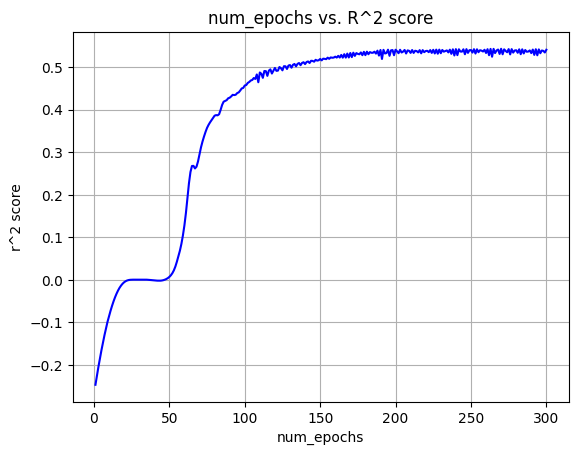

In [27]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [28]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5426639412798423
Corresponding RMSE: 0.20551823921919735
Corresponding num_epochs: 270
